In [1]:
from util.activation_visualization import effective_receptive_field, rescaleZeroOne, multiplot
from models.model_builder import load_model
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
from tqdm import tqdm
from joblib import Parallel, delayed
from torchinfo import summary
import yaml
import os

from util import fit_gabor_filter, find_files_in_folder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [126]:
model_base_path = "../models/lindsey_weight_reg_act/l2reg_tanh" # "../models/lindsey_weight_reg_grid_color/l2reg_2e-4" # 
logfile = os.path.join(os.path.split(model_base_path)[0],"logs",os.path.split(model_base_path)[1]+".yaml")
with open(logfile, "r") as file:
    log = yaml.load(file, Loader=yaml.FullLoader)
files = find_files_in_folder(model_base_path, "e**.pth")

In [127]:
epoch_effs=[]
for i, model_path in enumerate(files[:]):
    model = load_model(model_base_path, weights_file=model_path)
    model = model.get_sequential()
    model = model.to(device)
    eff_rfs = effective_receptive_field(model[:7], n_batch=1, fill_value=0.5, device=device)
    epoch_effs.append(eff_rfs)

100%|██████████| 32/32 [00:00<00:00, 183.30it/s]


In [128]:
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            7,808
├─Tanh: 1-2                              --
├─Conv2d: 1-3                            82,976
├─Tanh: 1-4                              --
├─Conv2d: 1-5                            82,976
├─Tanh: 1-6                              --
├─Conv2d: 1-7                            82,976
├─Tanh: 1-8                              --
├─Flatten: 1-9                           --
├─Linear: 1-10                           33,555,456
├─Tanh: 1-11                             --
├─Linear: 1-12                           10,250
├─Softmax: 1-13                          --
Total params: 33,822,442
Trainable params: 33,822,442
Non-trainable params: 0

In [129]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (1): Tanh()
  (2): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (3): Tanh()
  (4): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (5): Tanh()
  (6): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (7): Tanh()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=32768, out_features=1024, bias=True)
  (10): Tanh()
  (11): Linear(in_features=1024, out_features=10, bias=True)
  (12): Softmax(dim=-1)
)

In [130]:
def set_border_color(ax, color):
    if isinstance(color, (np.floating, float)):
        color = (color, color, color)
    ax.spines['top'].set_color(color)
    ax.spines['bottom'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)

In [131]:
max_plots = 64*3
num_cols=16
max_epochs=120
num_rows = max(1,min(len(epoch_effs[0]),max_plots)//num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,num_rows*2))
imshows = []
scaled_effs = np.array(epoch_effs)
global_max = np.max(np.abs(scaled_effs[~np.isnan(scaled_effs)]))
for i, (eff_rf, ax) in enumerate(zip(scaled_effs[-1], axes.flat)):
    if eff_rf.shape[0] == 3:
        eff_rf = eff_rf.swapaxes(0,2)
    else:
        eff_rf = eff_rf[0]
    min_max = np.max(np.abs(eff_rf))
    eff_rf = (eff_rf+min_max)/(2*min_max)
    imshows.append(ax.imshow(eff_rf, cmap="gray"))
    ax.set_title(str(i))
    ax.set_xticks([])
    ax.set_yticks([])
    set_border_color(ax, 1-min_max/global_max)

    linewidth = 5
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    plt.setp(ax.get_yticklines(),visible=False)
    plt.setp(ax.get_xticklines(),visible=False)
    plt.setp(ax.get_yticklabels(),visible=False)
    plt.setp(ax.get_xticklabels(),visible=False)
for ax in axes.flat[len(epoch_effs[0]):]:
    ax.axis('off')
title = fig.suptitle("Epoch 0", fontsize=16)
plt.tight_layout()

def update(frame):
    for img, eff_rf, ax in zip(imshows,scaled_effs[frame], axes.flat):
        if eff_rf.shape[0] == 3:
            eff_rf = eff_rf.swapaxes(0,2)
        else:
            eff_rf = eff_rf[0]
        min_max = np.max(np.abs(eff_rf))
        eff_rf = (eff_rf+min_max)/(2*min_max)
        img.set_data(eff_rf)
        set_border_color(ax, 1-min_max/global_max)
    title.set_text(f"Epoch {frame}")

# Create the animation
ani = FuncAnimation(fig, update, frames=min(len(epoch_effs), max_epochs), interval=200)
display(HTML(ani.to_jshtml()))
plt.close()

In [132]:
a

NameError: name 'a' is not defined

In [ ]:
path = "../imgs/regularization/l1_actreg_1e-7_l4.gif"
writer = PillowWriter(bitrate=180)
ani.save(path, writer)

In [ ]:
params = []
for i, model_path in enumerate(files[:]):
    model = load_model(model_base_path, weights_file=model_path)
    params.append(np.concatenate([p.detach().numpy().flatten() for p in model.parameters()]))
params = np.array(params)

In [ ]:
max_line = np.max(params, axis=1)
min_line = np.min(params, axis=1)
mean_line = np.mean(params, axis=1)

In [ ]:
penalty = np.sum(params*params, axis=1)

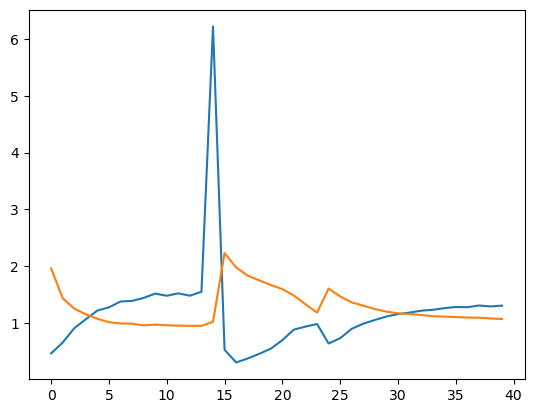

In [ ]:
plt.plot(penalty*log["weight_decay"])
plt.plot(log["train_loss"])
plt.show()

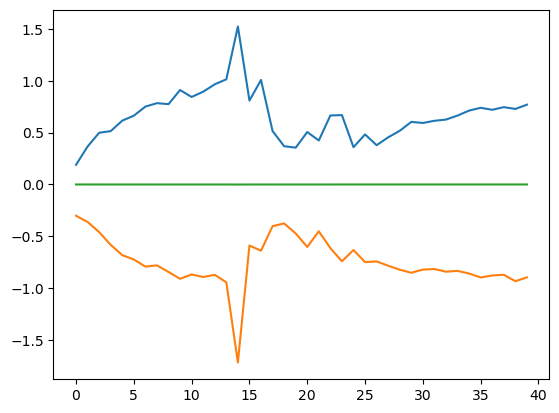

In [ ]:
plt.plot(np.array([max_line, min_line, mean_line]).T)
plt.show()

In [ ]:
aaa

NameError: name 'aaa' is not defined

In [210]:
import palettable
import cmcrameri
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [206]:
colors = [[10/255,64/255,113/255], [0/255,209/255,128/255]]

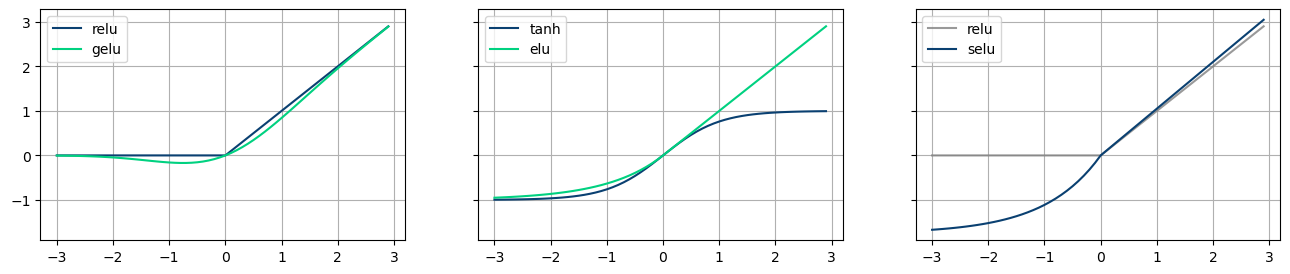

In [230]:
x = torch.arange(-3,3,0.1)
selu = torch.nn.functional.selu(x)
elu = torch.nn.functional.elu(x)
relu = torch.nn.functional.relu(x)
gelu = torch.nn.functional.gelu(x)
tanh = torch.nn.functional.tanh(x)
fig, axes = plt.subplots(1,3, figsize=(16,3), sharey=True)
for ax in axes.flat:
    ax.set_prop_cycle('color', colors)
    ax.grid(True)
axes[0].plot(x, np.stack([relu, gelu]).T)
axes[0].legend(["relu", "gelu"])
axes[1].plot(x, np.stack([tanh, elu]).T)
axes[1].legend(["tanh", "elu"])
axes[2].plot(x, relu, color="grey", alpha=0.8)
axes[2].plot(x, selu)
axes[2].legend(["relu", "selu"])
plt.show()

In [ ]:
with open("../imgs/rf_development/alexnet_sgd_no_momentum.html", "w") as f:
    print(ani.to_jshtml(), file=f)

In [ ]:
epoch_fits = []
fit_mses=np.zeros((len(epoch_effs), len(epoch_effs[0])))

for i_epoch, effs in enumerate(tqdm(epoch_effs)):
    result_generator = Parallel(n_jobs=48)(delayed(fit_gabor_filter)(rescaleZeroOne(eff_rf.numpy()), wavelength=None, maxiter=200) for eff_rf in effs)
    result = list(result_generator)
    fit_mses[i_epoch] = np.array([res[1] for res in result])
    epoch_fits.append([res[0] for res in result])

: 

In [ ]:
max_plots = 32
num_rows = max(1,min(len(epoch_fits[0]),max_plots)//8)
fig, axes = plt.subplots(num_rows, 8, figsize=(12,num_rows*2))
imshows = []
cmap = plt.get_cmap('winter_r')
good_fit=np.quantile(fit_mses[~np.isnan(fit_mses)], 0.5)

for i, (eff_rf, ax, fit_mse) in enumerate(zip(epoch_fits[-1][:max_plots], axes.flat,fit_mses[-1])):
    imshows.append(ax.imshow(eff_rf, cmap="gray"))
    ax.set_title(str(i), color=cmap(fit_mse/good_fit))
    ax.axis('off')
title = fig.suptitle("Epoch 0", fontsize=16)

def update(frame):
    for img, eff_rf, ax, fit_mse in zip(imshows,epoch_fits[frame], axes.flat, fit_mses[frame]):
        img.set_data(eff_rf)
        ax.title.set_color(cmap(fit_mse/good_fit))
    title.set_text(f"Epoch {frame}")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(epoch_fits), interval=200)
display(HTML(ani.to_jshtml()))
plt.close()

: 

In [ ]:
gaborish_rfs = np.argsort(fit_mses[-1])#np.argwhere(fit_mses[-1]<good_fit).flatten()

num_rows = max(1,np.ceil(min(len(gaborish_rfs),max_plots)/8).astype(int))
fig, axes = plt.subplots(num_rows, 8, figsize=(12,num_rows*2))

for i, eff_rf, ax, fit_mse in zip(gaborish_rfs, np.array(epoch_effs[-1])[gaborish_rfs], axes.flat,fit_mses[-1, gaborish_rfs]):
    imshows.append(ax.imshow(eff_rf, cmap="gray"))
    ax.set_title(str(i)+': {:.1e}'.format(fit_mse), color=cmap(fit_mse/good_fit))
for ax in axes.flatten():
    ax.axis('off')

title = fig.suptitle("Filters sorted by their Gaborishness", fontsize=16)
plt.show()

: 

In [ ]:
plt.plot(fit_mses[:])
plt.show()

: 